In [2]:
import sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../file_loader')
sys.path.append('../preprocessing-block')

import ecg_file_loader
from ecg_file_loader import ECGFileLoader

import pantompkins
from pantompkins import *

reload(ecg_file_loader)
reload(pantompkins)


<module 'pantompkins' from '/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/• src_blocks/check_codes/../preprocessing-block/pantompkins.py'>

### Very easy just to test

In [ ]:
import neurokit2 as nk
import mne

# ecg_signal
ecg_signal = "/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/scr/Open_Neuro/data/sub-001/ses-01/ecg/sub-001_ses-01_task-szMonitoring_run-01_ecg.edf"

raw = mne.io.read_raw_edf(ecg_signal, preload=True, verbose=False)

# Get the ECG data as a numpy array (channels x samples)
ecg_data = raw.get_data()

# If there is only one channel, flatten to 1D
ecg_1d = ecg_data[0]
print(ecg_1d.shape)

sampling_rate = raw.info['sfreq']
print(f"Sampling rate: {sampling_rate} Hz")

#signals, info = nk.ecg_process(ecg_1d, sampling_rate=sampling_rate, method="pantompkins1985")
ecg_1d_clean = nk.ecg_clean(ecg_1d, sampling_rate=sampling_rate, method="pantompkins1985")
signals, info = nk.ecg_peaks(ecg_1d_clean, sampling_rate=sampling_rate, method="pantompkins1985")


rpeaks = info["ECG_R_Peaks"]
print(rpeaks)

(16721664,)
Sampling rate: 256.0 Hz
[      77      160      240 ... 16720448 16720685 16720898]
[      77      160      240 ... 16720448 16720685 16720898]


# Using the `pantompkins.py` file

In [2]:
loader = ECGFileLoader(use_s3=False)

In [38]:
processed_data = process_all_patients_pantompkins(loader, ['sub-004'], method='neurokit')

INFO:pantompkins:Processing Pan-Tompkins for 1 patients: ['sub-004']
INFO:pantompkins:Loading data for patient sub-004
INFO:ecg_file_loader:Processing sub-004 run 01
INFO:pantompkins:Processing sub-004 run 01
INFO:pantompkins:ECG signal shape: (17049600,), sampling rate: 256.0 Hz


cleaning done


INFO:pantompkins:Successfully processed sub-004 run 01: 76897 R-peaks detected
INFO:pantompkins:Completed Pan-Tompkins processing for 1 runs
INFO:pantompkins:Completed processing for patient sub-004: 1 runs


In [39]:
print(type(processed_data))                      # should be dict
print(type(processed_data['sub-004']))           # should be list
print(type(processed_data['sub-004'][0]))        # should be dict
print(processed_data['sub-004'][0].keys())       # shows the available data fields

print(" ")

<class 'dict'>
<class 'list'>
<class 'dict'>
dict_keys(['patient_id', 'run_number', 'seizure_events', 'annotations', 'ecg_signal', 'sampling_rate', 'duration_seconds', 'method_signals', 'method_info', 'rpeaks', 'rpeaks_times', 'rr_intervals_ms', 'num_beats', 'processing_method'])
 


`ecg_raw`: The original MNE Raw object for the ECG run (full metadata, channels, etc.).

`ecg_signal`: The raw ECG signal as a 1D NumPy array (just the signal values, usually in volts).

`pantompkins_signals`: Output from NeuroKit2’s ecg_peaks function; a DataFrame with columns like 'ECG_R_Peaks' (binary vector marking R-peak locations).

`pantompkins_info`: Dictionary from NeuroKit2 with detailed info, including the 'ECG_R_Peaks' array (indices of R-peaks).

`rpeaks`: The sample indices of detected R-peaks (same as pantompkins_info["ECG_R_Peaks"]).

`rpeaks_times`: The times (in seconds) of each R-peak (i.e., rpeaks / sampling_rate).

`rr_intervals_ms`: The RR intervals (in milliseconds) between consecutive R-peaks.

In [1]:
processed_data['sub-004'][0]['rr_intervals_ms']

NameError: name 'processed_data' is not defined

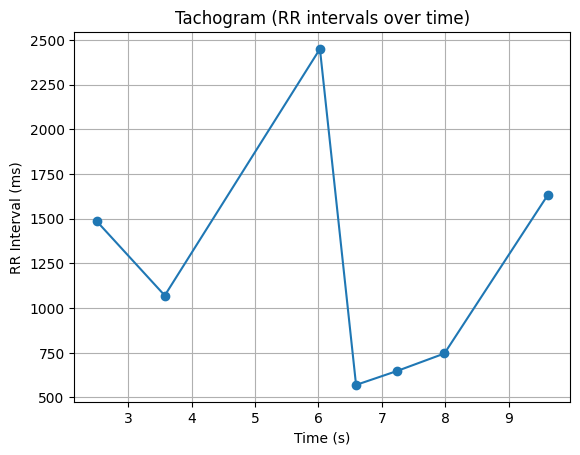

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk


time_axis = processed_data['sub-004'][0]['rpeaks_times'][1:]
rr_intervals_ms = processed_data['sub-004'][0]['rr_intervals_ms']


# Keep only first 10 seconds
mask = time_axis <= 10
time_10s = time_axis[mask]
rr_10s = rr_intervals_ms[mask]

plt.plot(time_10s, rr_10s, marker='o')    

plt.title("Tachogram (RR intervals over time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)
plt.show()


### Plotting

In [42]:
def plot_ecg_with_rpeaks(processed_run_data, time_window_seconds=30, start_time=0):

    # Extract data
    ecg_signal = processed_run_data['sub-004'][0]['ecg_signal']
    rpeaks = processed_run_data['sub-004'][0]['rpeaks']
    sampling_rate = processed_run_data['sub-004'][0]['sampling_rate']
    seizure_events = processed_run_data['sub-004'][0]['seizure_events']
    
    # Calculate sample indices for the time window
    start_sample = int(start_time * sampling_rate)
    end_sample = int((start_time + time_window_seconds) * sampling_rate)
    end_sample = min(end_sample, len(ecg_signal))
    
    # Extract signal segment
    time_axis = np.arange(start_sample, end_sample) / sampling_rate
    ecg_segment = ecg_signal[start_sample:end_sample]
    
    # Filter R-peaks within the time window
    rpeaks_in_window = rpeaks[(rpeaks >= start_sample) & (rpeaks < end_sample)]
    rpeaks_times = rpeaks_in_window / sampling_rate
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot ECG signal
    plt.plot(time_axis, ecg_segment * 1e6, 'b-', linewidth=0.8, label='ECG Signal')
    
    # Plot R-peaks
    if len(rpeaks_in_window) > 0:
        rpeak_values = ecg_signal[rpeaks_in_window] * 1e6
        plt.scatter(rpeaks_times, rpeak_values, color='red', s=50, zorder=5, label=f'R-peaks ({len(rpeaks_in_window)})')
    
    # Mark seizure events if any overlap with the time window
    for i, seizure in enumerate(seizure_events):
        seizure_start = seizure['onset_time']
        seizure_end = seizure_start + seizure['duration']
        
        # Check if seizure overlaps with our time window
        if seizure_start < (start_time + time_window_seconds) and seizure_end > start_time:
            plt.axvspan(max(seizure_start, start_time), 
                       min(seizure_end, start_time + time_window_seconds), 
                       alpha=0.3, color='orange', 
                       label=f'Seizure {i+1}' if i == 0 else "")
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('ECG Amplitude (μV)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Statistics for this window:")
    print(f"  R-peaks detected: {len(rpeaks_in_window)}")
    if len(rpeaks_in_window) > 1:
        window_rr = np.diff(rpeaks_in_window) / sampling_rate * 1000
        window_hr = 60000 / np.mean(window_rr)
        print(f"  Average RR interval: {np.mean(window_rr):.1f} ms")
        print(f"  Average heart rate in window: {window_hr:.1f} bpm")

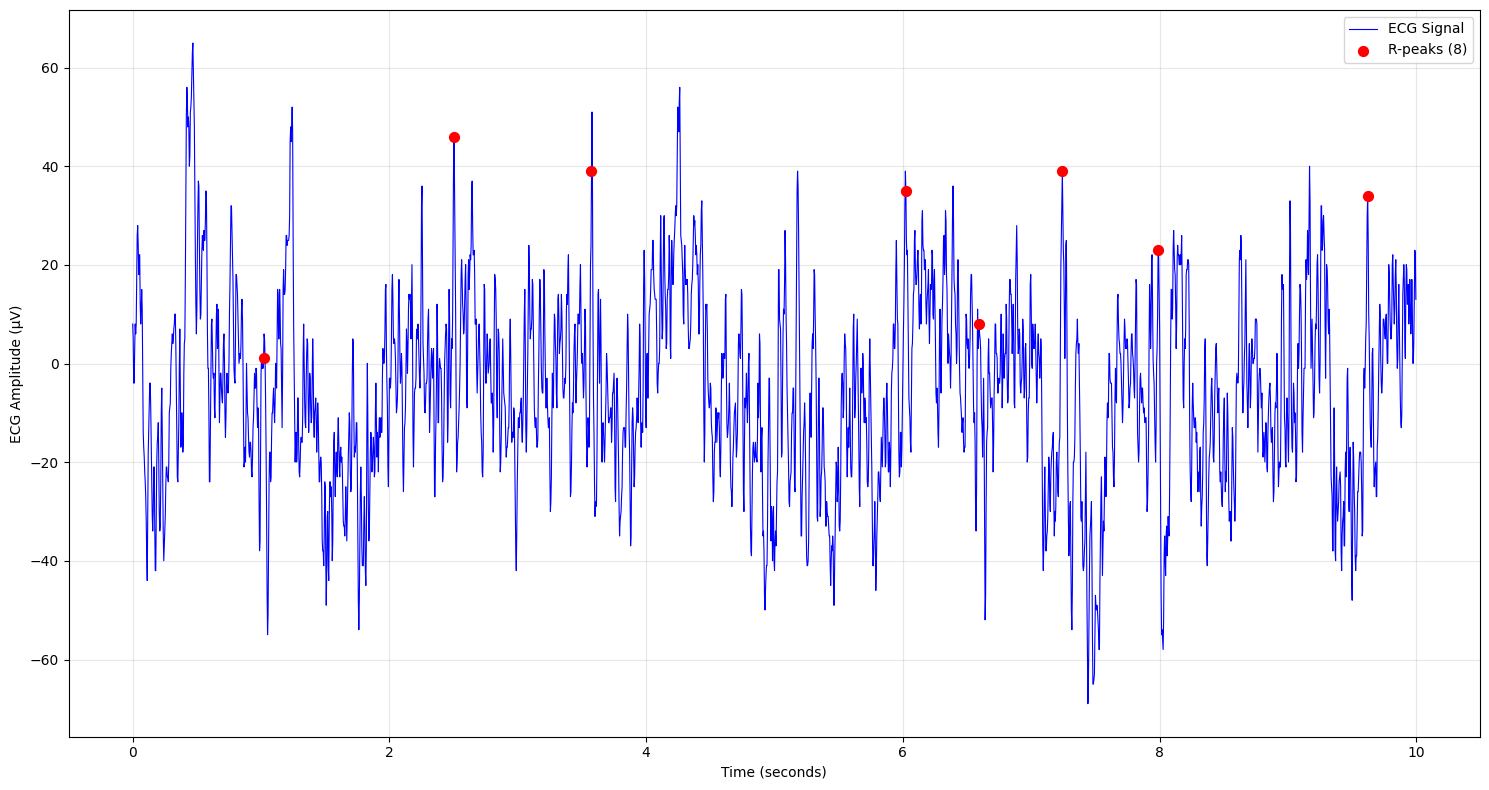

Statistics for this window:
  R-peaks detected: 8
  Average RR interval: 1228.8 ms
  Average heart rate in window: 48.8 bpm

Plotting around first seizure at 1359.0s:


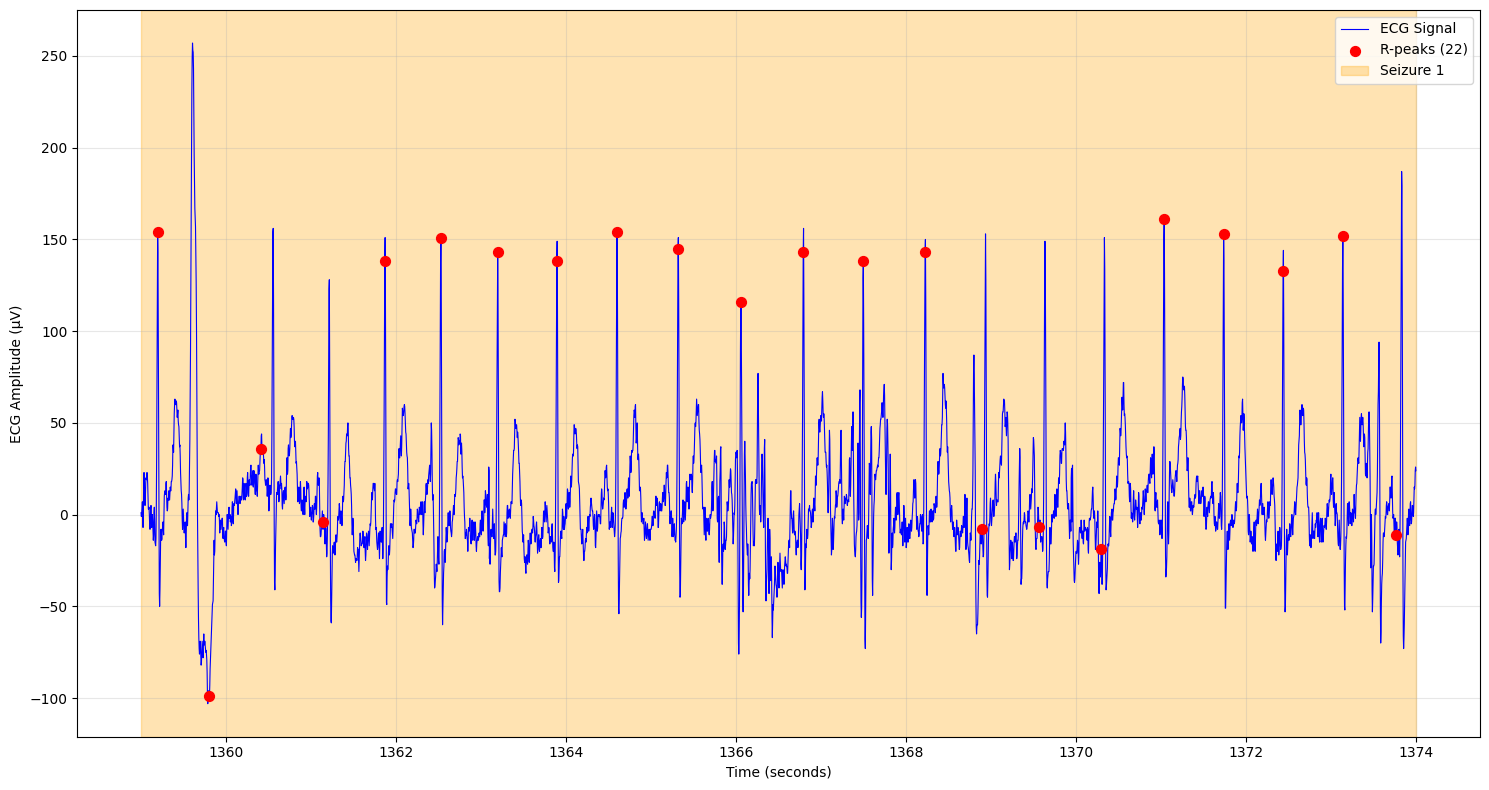

Statistics for this window:
  R-peaks detected: 22
  Average RR interval: 693.8 ms
  Average heart rate in window: 86.5 bpm


In [43]:
plot_ecg_with_rpeaks(processed_data, time_window_seconds=10, start_time=0)

# If there are seizure events, plot around the first seizure
if processed_data['sub-004'][0]['seizure_events']:
    first_seizure = processed_data['sub-004'][0]['seizure_events'][0]
    seizure_start = first_seizure['onset_time']
    
    print(f"\nPlotting around first seizure at {seizure_start:.1f}s:")
    # Plot 30 seconds starting 15 seconds before seizure
    plot_ecg_with_rpeaks(processed_data, time_window_seconds=15, start_time=max(0, seizure_start - 0))